# Chapter 4: Computing Sea Ice Extent and Plotting a Time Series Graph
* **Creators:** Ann Windnagel and Robyn Marowitz
* **Affiliation:** [National Snow and Ice Data Center (NSIDC)](https://nsidc.org/home "National Snow and Ice Data Center")
* **History:**
  * 8 January 2025 - Initial version

## Overview

In this notebook, you will learn how to compute sea ice extent (SIE) for a year's worth of data and graph the time series.

### Prerequisites
Read and understand the material in Notebook 2.

### Targeted Level

Intermediate

### Learning Outcomes
Once you have completed this notebook, you will be able to:
* Open a netCDF file using the python NetCDF4 library and explore how this differs from using Xarray to open a netCDF file
* Compute sea ice extent from gridded sea ice concentration data using a grid cell area file
* Create a time series graph of sea ice extent for one year

### Time Estimate
TBD

<div class="alert alert-block alert-info">
<h3><strong>Note</strong></h3>
This notebook utilizes some ancillary pixel (grid cell) area files for the sea ice extent computations. These pixel area files are part of a NASA dataset that is behind an EARTHDATA Login. For the ease of use in this notebook, we have downloaded the necessary files and placed them in the `ancillary_files` folder in this repo. If you are interested, you can learn more about these ancillary files here: https://nsidc.org/data/nsidc-0771. There are two files, one for each hemisphere:
    <ul>
    <li>Northern Hemisphere: NSIDC0771_CellArea_PS_N25km_v1.0.nc</li>
    <li>Southern Hemisphere: NSIDC0771_CellArea_PS_S25km_v1.0.nc</li>
    </ul>
</div>

### Import Relevant Packages
You will use [NetCDF4](https://unidata.github.io/netcdf4-python/ "NetCDF4 documentation") to open the ancillary pixel area file which are in netCDF format. NetCDF4 is a Python interface to the netCDF C library that is used to read in information from netCDF files.

In [1]:
import pystac
import fsspec
import csv
import numpy as np
import xarray as xr
import numpy.ma as ma
from netCDF4 import Dataset
from datetime import datetime, timedelta, date
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

************************
## Tutorial

Calculate sea ice extent and plot a time series graph
*************************

###  Read the STAC Collection and NetCDF Files and Extract the Sea Ice Concentration Data
To begin, you will once again download the desired file via STAC like we did in the previous notebooks and extract the sea ice concentration data. You will be using 2023 Southern Hemisphere data again for this tutorial.

In [2]:
# Specify the URL to the sea ice CDR collection.json file on NSIDC servers
collection_url = 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/stac/collection.json'
# Read file and assign to a variable
collection = pystac.Collection.from_file(collection_url)

# Extract items from the collection
items = list(collection.get_all_items())

# Extract all the Item IDs from the item list
item_ids = [i.id for i in items]

# Find the item id for the 2023 daily SH file
# This command returns a list with one element that contains the id you want
daily_sh_2023_id = [i for i in item_ids if "daily_sh_2023" in i]

# Get item using item id
daily_sh_2023_item = collection.get_item(daily_sh_2023_id[0], recursive=True)

# Get the URL from the STAC Item assets
netcdf_url_2023 = daily_sh_2023_item.assets['netcdf'].href

# Read the netCDF file at that URL using fsspec and xarray and print out the result
fs_2023 = fsspec.filesystem('https')
ds_2023 = xr.open_dataset(fs_2023.open(netcdf_url_2023))

# Pull out sea ice concentration variable and then put the data into a numpy array
cdr_seaice_conc_2023 = ds_2023.variables['cdr_seaice_conc']
cdr_seaice_conc_2023_np = np.array(cdr_seaice_conc_2023.data)

### Open Southern Hemisphere Pixel Area File Using NetCDF4 Python Library
You've learned how to use `xarray` to open netCDF files. This time you will use another popular Python library to do the job. You will use the Python `netCDF4` library to open the Southern Hemisphere pixel area netCDF file. You will need this file to compute a total sea ice extent from sea ice concentration grids for a given date. This will be explained more fully later in the notebook; but for now, let's open the file and explore its contents and the differences between `xarray` and `netCDF4` libraries.

In [3]:
# Open Southern Hemsiphere pixel area file
pixel_area_sh_fn = 'ancillary_files/NSIDC0771_CellArea_PS_S25km_v1.0.nc'
pixel_area_sh_nc = Dataset(pixel_area_sh_fn, 'r')

<div class="alert alert-block alert-success">
<h3><strong>Explore</strong></h3>
<h4>Check out the similarities and differences between a netCDF file opened as an Xarry Dataset and as a NetCDF4 Dataset</h4>
Things you'll notice between the two ways of opening netCDF data files:
    
* Both ways of opening a netCDF file allow you access to the data variables and metadata within the netCDF file.
* The instances of the data have different data types. You can view these using the `type()` method.
* When you print out the data opened with Xarray (in this case `ds_2023`), it provides a compact interactive way to view the file contents, as you saw in Notebook 2.
* When you print data opened from NetCDF4 (in this case `pixel_area_nc`), it simply prints out all the text in one long chunk associated with the global metadata and variable metadata.
* As with the Xarray dataset, you can print specific parts of the metadata and variables for a NetCDF4 dataset with methods and objects.
</div>

In [4]:
# Print out the data types of an Xarray dataset and a NetCDF4 dataset
print('Xarray datatype: ', type(ds_2023))
print('NetCDF4 datatype: ',type(pixel_area_sh_nc))

Xarray datatype:  <class 'xarray.core.dataset.Dataset'>
NetCDF4 datatype:  <class 'netCDF4._netCDF4.Dataset'>


In [5]:
# Print out the contents of the Xarray dataset instance
ds_2023

<xarray.Dataset> Size: 1GB
Dimensions:                      (tdim: 365, y: 332, x: 316)
Coordinates:
    time                         (tdim) datetime64[ns] 3kB ...
    xgrid                        (x) float32 1kB ...
    ygrid                        (y) float32 1kB ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc              (tdim, y, x) float32 153MB 0.0 0.0 ... 0.0 0.0
    nsidc_bt_seaice_conc         (tdim, y, x) float32 153MB ...
    nsidc_nt_seaice_conc         (tdim, y, x) float32 153MB ...
    projection                   |S1 1B ...
    qa_of_cdr_seaice_conc        (tdim, y, x) float32 153MB ...
    spatial_interpolation_flag   (tdim, y, x) float32 153MB ...
    stdev_of_cdr_seaice_conc     (tdim, y, x) float32 153MB ...
    temporal_interpolation_flag  (tdim, y, x) float32 153MB ...
    latitude                     (y, x) float32 420kB ...
    longitude                    (y, x) float32 420kB ...
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-09-26T20:17:19Z
    time_coverage_start:       2023-01-01T00:00:00Z
    time_coverage_end:         2023-12-31T23:59:59Z

In [6]:
# Print out the contents of the NetCDF4 dataset instance
pixel_area_sh_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Polar Stereo Ancillary Grid Information
    summary: This data set provides the total on-Earth surface area and the the latitude and longitude values at the center of each grid cell of the 6.25km, 12.5km, and 25km polar stereographic gridded data sets distributed by The National Snow and Ice Data Center
    id: 10.5067/N6INPBT8Y104
    metadata_link: https://doi.org/10.5067/N6INPBT8Y104
    license: Access Constraint: These data are freely, openly, and fully accessible, provided that you are logged into your NASA Earthdata profile (https://urs.earthdata.nasa.gov/);  Use Constraint: These data are freely, openly, and fully available to use without restrictions, provided that you cite the data according to the recommended citation at https://nsidc.org/about/use_copyright.html. For more information on the NASA EOSDIS Data Use Policy, see https://earthdata.nasa.gov/earth-observation-data/data-u

In [7]:
# Print just the names of the variables in the NetCDF4 dataset
pixel_area_sh_nc.variables.keys()

dict_keys(['x', 'y', 'crs', 'cell_area'])

In [8]:
# Print the variables with their metadata
pixel_area_sh_nc.variables

{'x': <class 'netCDF4._netCDF4.Variable'>
 float64 x(x)
     standard_name: projection_x_coordinate
     long_name: x coordinate of projection
     units: meters
     axis: X
     valid_range: [-3950000.  3950000.]
 unlimited dimensions: 
 current shape = (316,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'y': <class 'netCDF4._netCDF4.Variable'>
 float64 y(y)
     standard_name: projection_y_coordinate
     long_name: y coordinate of projection
     units: meters
     axis: Y
     valid_range: [-3950000.  4350000.]
 unlimited dimensions: 
 current shape = (332,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'crs': <class 'netCDF4._netCDF4.Variable'>
 int32 crs()
     grid_mapping_name: polar_stereographic
     straight_vertical_longitude_from_pole: 0.0
     false_easting: 0.0
     false_northing: 0.0
     latitude_of_projection_origin: -90.0
     standard_parallel: -70.0
     long_name: NSIDC_SH_PolarStereo_25km
     longitude_of_prime_meridian: 0.

### Extract Cell Area from NetCDF4 Dataset
As you saw from exploring the contents of the `pixel_area_nn` data above, the variable that we need is called `cell_area`. You will extract the cell area into a numpy array and then convert the values from square meters to square kilometers to the numbers are easier to work with and view. 

<div class="alert alert-block alert-info">
<strong>Hint:</strong> The slicing operator <code>[:]</code> extracts the data from the NetCDF variable and converts it to a NumPy array.
</div>


In [9]:
# Get cell area and put in a numpy array
pixel_area_sh = pixel_area_sh_nc.variables['cell_area']
pixel_area_sh_np = pixel_area_sh[:]

# Divide area by 1 million to convert from square meters to square kilometers
pixel_area_sh_scaled = pixel_area_sh_np/1000000

### Calculate Sea Ice Extent
The SIC CDR data are in a polar stereographic projection and grid where each grid cell has a different area. To compute sea ice extent, you will multiply each grid cell that contains sea ice at a greater than 15% concentration by the area of the grid cell and then sum them up to get total extent for each day. You will loop over each day in the `ds_2023` dataset to calculate the SIE for each day and save it into a pandas dataframe. Here's an overview of the processing steps to calculate SIE from the SIC CDR daily grids:

1. Extract the `time` variable from the data so you can keep track of the date of the SIE you calculate
2. Extract a single day's grid of SIC data
3. Convert the SIC from a fraction to a percent so we can work with whole numbers
4. Mask out land surface values and SIC less than 15%. Remember from Notebook 1 and Notebook 3 that a common threshold for sea ice concentrations is 15%. You will apply this 15% threshold to the SIC CDR data before calculating the SIE.
5. Set all remaining sea ice concentration grid cells to 1. This step is done when computing sea ice extent because, for ice extent, the concentration of a grid cell is assumed to be 100% for any concentration greater than 15%. There is another calculation called sea ice area that considers the actual percent concentration at a grid cell, but that is not explored here.
6. Multiply each grid cell with sea ice by the area of that grid cell.
7. Sum up all the areas to compute total extent
8. Loop through all the days of the year to compute extent for each

<div class="alert alert-block alert-success">
<h3><strong>Explore</strong></h3>
To learn more about the difference between sea ice extent and sea ice area visit NSIDC's <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent" title="What is the difference between sea ice area and extent">What is the difference between sea ice area and extent?</a>
</div>

In [10]:
# Extract the date and time from the SIC data
file_time = ds_2023.variables['time']
# Get year from STAC item property
year = daily_sh_2023_item.properties['start_datetime'][:4]

# Create an empty list to store sea ice extent data
sie_list = []

# Calculate daily extent for each day and save to a pandas dataframe
for t in range(len(cdr_seaice_conc_2023_np)):
    # Here we are squeezing so we have a 2D array for each day
    cdr_seaice_conc_2d = np.copy(cdr_seaice_conc_2023_np[t,:,:].squeeze())
    
    # Convert from fractional sea ice to percent and round to the ones place so that we work with whole numbers. 
    # This alleviates any issues with round off error when we threshold the extent at 15%
    cdr_seaice_conc_2d_percent = cdr_seaice_conc_2d*100
    cdr_seaice_conc_2d_percent = np.round(cdr_seaice_conc_2d_percent, 1)

    # Compute Extent
    # Create mask to filter out the flag values from the computation and concentration equal to or less than 15%
    # Flag values are 251, 252, 253, 254, 255
    # This line removes flag values and concentration < 15%
    flag_mask_extent = ma.masked_outside(cdr_seaice_conc_2d_percent, 15, 251)

    # Set all remaining grid cells that contain sea ice concentraiton to 1
    non_mask_extent = ma.nonzero(flag_mask_extent)
    flag_mask_extent[non_mask_extent] = 1.0

    # Mulitply the grid cells with sea ice by the area of the grid cell
    sea_ice_extent_raster = flag_mask_extent * pixel_area_sh_scaled

    # Sum all grid cells to get a total sea ice extent
    cdr_seaice_extent_total = sea_ice_extent_raster.sum()

    # Set the day of year (doy)
    doy = t + 1
    # Create the date from the year and the day of year (doy) for the SIE just computed
    date = datetime.strptime(f'{year} {doy}', '%Y %j')
    
    # Add the SIE and the date to the list
    sie_list.append(
        {
            'yyyy/mm/dd': date, 
            'Extent(km2)': cdr_seaice_extent_total
        }
    )

# Create pandas dataframe from list
extent_df = pd.DataFrame(sie_list)

### Review the Data in the Dataframe

In [11]:
# Set display options for pandas
pd.options.display.float_format = '{:20,.2f}'.format

# Show dataframe
extent_df.head()

,yyyy/mm/dd,Extent(km2)
0,2023-01-01,"4,969,503.44"
1,2023-01-02,"4,737,612.40"
2,2023-01-03,"4,637,743.40"
3,2023-01-04,"4,478,236.57"
4,2023-01-05,"4,345,070.47"


### Plot a time series of the sea ice extent

You can see from this one year of ice extent data that the Southern Hemisphere experiences a minimum during summertime (February/March) and a maximum during the winter (September). As noted in Notebook 3, the lowest minimum ever recorded for the Southern Hemisphere occurred on 21 February 2023.

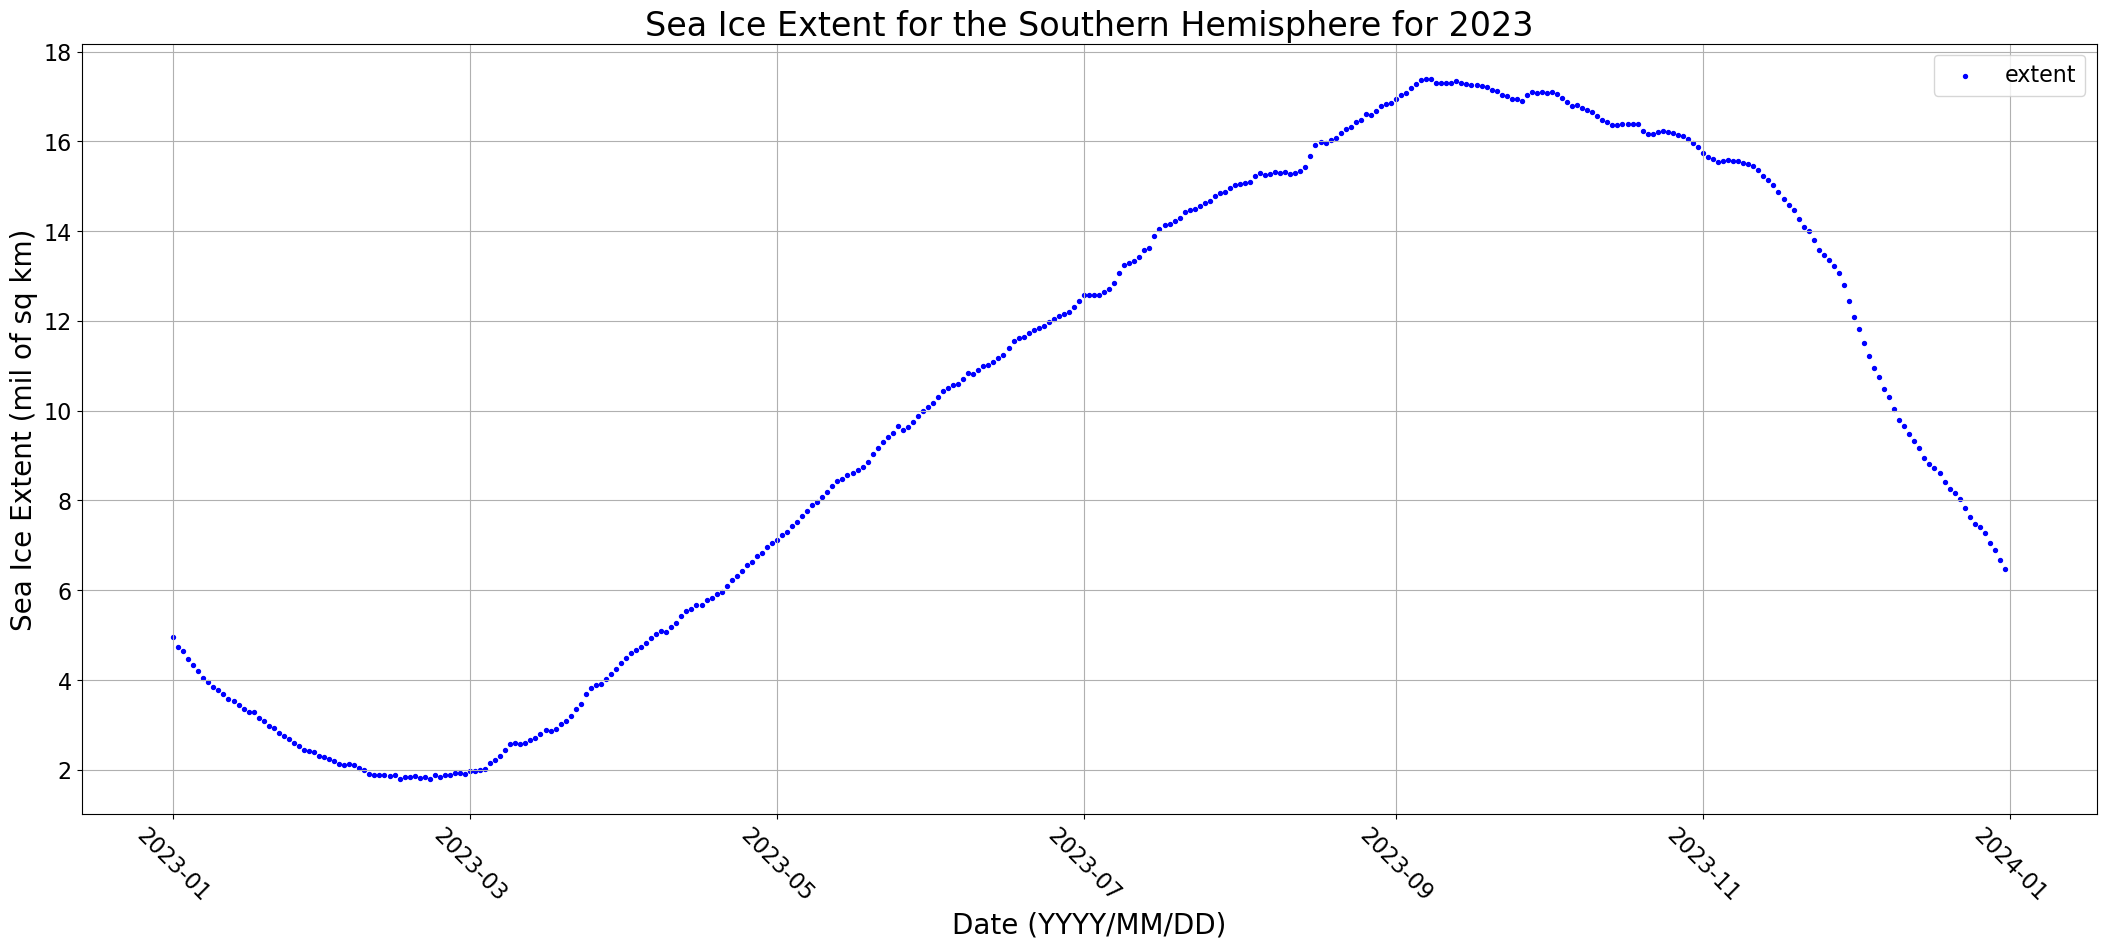

In [12]:
# Set up plot space
fig, ax1 = plt.subplots(figsize=(26, 10))

# Plot extent. Divide extent by 1 million to convert sq km to millions of sq km so that the y-axis values are easier to read
plt.scatter(extent_df['yyyy/mm/dd'], extent_df['Extent(km2)']/10e5, color='blue', 
            label='extent', s=8)

# Set labels and ticks
plt.title("Sea Ice Extent for the Southern Hemisphere for 2023", fontsize=24)
plt.xlabel("Date (YYYY/MM/DD)", fontsize=20)
plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20)
plt.xticks(rotation=-45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

### Save the dataframe to a CSV file
Note: The code in the cell below is commented out so that a file won't be saved because a copy already exists in the GitHub repo. However, if you would like to save the file as part of your work with these notebooks, then uncomment out lines 2 and 5 below. You will need this CSV file for use in the tutorial in Notebook 5.

In [13]:
# CSV filename
#cdr_sh_fn = 'data_files/cdr_sie_SH_2023.csv'

# Save the dataframe to the CSV file
#extent_df.to_csv(cdr_sh_fn, sep=',', index=False)

<div class="alert alert-block alert-success">
<h3><strong>Exercise</strong></h3>
Using the example from this Tutorial, uncomment the template below, and change the code as necessary to calculate sea ice extent for the Northern Hemisphere for 2012. </br></br>
<strong>Be sure to update variable names and map titles as appropriate as well.</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Hint:</strong> Think about what you need to search for to find the correct `Item id` for the daily 2012 Northern Hemisphere <em>Item</em>.
</div>

### Get the 2012 Northern Hemisphere Data

In [14]:
# Find the item id for the 2012 daily NH file
# This command returns a list with one element that contains the id you want
#daily_sh_2023_id = [i for i in item_ids if "daily_sh_2023" in i] # Uncomment out this command and update as necessary

# Get item using item id
#daily_sh_2023_item = collection.get_item(daily_sh_2023_id[0], recursive=True) # Uncomment out this command and update as necessary

# Get the URL from the STAC Item assets
#netcdf_url_2023 = daily_sh_2023_item.assets['netcdf'].href # Uncomment out this command and update as necessary

# Read the netCDF file at that URL using fsspec and xarray and print out the result
#fs_2023 = fsspec.filesystem('https') # Uncomment out this command and update as necessary
#ds_2023 = xr.open_dataset(fs_2023.open(netcdf_url_2023)) # Uncomment out this command and update as necessary

# Pull out sea ice concentration variable and then put the data into a numpy array
#cdr_seaice_conc_2023 = ds_2023.variables['cdr_seaice_conc'] # Uncomment out this command and update as necessary
#cdr_seaice_conc_2023_np = np.array(cdr_seaice_conc_2023.data) # Uncomment out this command and update as necessary

### Open Northern Hemisphere Pixel Area File and Extract Cell Area

In [15]:
# Open Northern Hemsiphere pixel area file
# NOTE: the NH filename has been updated for you here, but the variable names have not
#pixel_area_sh_fn = 'ancillary_files/NSIDC0771_CellArea_PS_N25km_v1.0.nc' # Uncomment out this command and update as necessary
#pixel_area_sh_nc = Dataset(pixel_area_sh_fn, 'r') # Uncomment out this command and update as necessary

# Get cell area and put in a numpy array
#pixel_area_sh = pixel_area_sh_nc.variables['cell_area'] # Uncomment out this command and update as necessary
#pixel_area_sh_np = pixel_area_sh[:] # Uncomment out this command and update as necessary

# Divide area by 1 million to convert from square meters to square kilometers
#pixel_area_sh_scaled = pixel_area_sh_np/1000000 # Uncomment out this command and update as necessary

### Calculate Sea Ice Extent for the Northern Hemisphere 2012 Data

In [16]:
# Extract the date and time from the SIC data
#file_time = ds_2023.variables['time'] # Uncomment out this command and update as necessary
# Get year from STAC item property
#year = daily_sh_2023_item.properties['start_datetime'][:4] # Uncomment out this command and update as necessary

# Create an empty list to store sea ice extent data
#sie_list = [] # Uncomment out this command

# Calculate daily extent for each day and save to a pandas dataframe
#for t in range(len(cdr_seaice_conc_2023_np)): # Uncomment out this command and update as necessary
    # Here we are squeezing so we have a 2D array for each day
    #cdr_seaice_conc_2d = np.copy(cdr_seaice_conc_2023_np[t,:,:].squeeze()) # Uncomment out this command and update as necessary
    
    # Convert from fractional sea ice to percent and round to the ones place so that we work with whole numbers. 
    # This alleviates any issues with round off error when we threshold the extent at 15%
    #cdr_seaice_conc_2d_percent = cdr_seaice_conc_2d*100 # Uncomment out this command
    #cdr_seaice_conc_2d_percent = np.round(cdr_seaice_conc_2d_percent, 1) # Uncomment out this command

    # Compute Extent
    # Create mask to filter out the flag values from the computation and concentration equal to or less than 15%
    # Flag values are 251, 252, 253, 254, 255
    # This line removes flag values and concentration < 15%
    #flag_mask_extent = ma.masked_outside(cdr_seaice_conc_2d_percent, 15, 251) # Uncomment out this command

    # Set all remaining grid cells that contain sea ice concentraiton to 1
    #non_mask_extent = ma.nonzero(flag_mask_extent) # Uncomment out this command
    #flag_mask_extent[non_mask_extent] = 1.0 # Uncomment out this command

    # Mulitply the grid cells with sea ice by the area of the grid cell
    #sea_ice_extent_raster = flag_mask_extent * pixel_area_sh_scaled # Uncomment out this command and update with NH pixel area variable name

    # Sum all grid cells to get a total sea ice extent
    #cdr_seaice_extent_total = sea_ice_extent_raster.sum() # Uncomment out this command

    # Set the day of year (doy) and extract the date for the SIE just computed
    #doy = t + 1 # Uncomment out this command
    #date = datetime.strptime(f'{year} {doy}', '%Y %j') # Uncomment out this command
    
    # Add the SIE and the date to the list
    #sie_list.append( # Uncomment out this command
    #    { # Uncomment out this command
    #        'yyyy/mm/dd': date, # Uncomment out this command 
    #        'Extent(km2)': cdr_seaice_extent_total # Uncomment out this command
    #    } # Uncomment out this command
    #) # Uncomment out this command

# Create pandas dataframe from list
#extent_df = pd.DataFrame(sie_list) # Uncomment out this command

### Plot Sea Ice Extent

Similarly to what you saw with the Southern Hemisphere graph for 2023, the Northern Hemisphere graph for 2012 shows that ice extent in the Northern Hemisphere experiences a minimum during summertime (September) and a maximum during the winter (March). As noted in Notebook 3, the lowest minimum ever recorded for the Northern Hemisphere occurred on 17 September 2012.

In [17]:
# Set up plot space
#fig, ax1 = plt.subplots(figsize=(26, 10)) # Uncomment out this command

# Plot extent. Divide extent by 1 million to convert sq km to millions of sq km so that the y-axis values are easier to read
#plt.scatter(extent_df['yyyy/mm/dd'], extent_df['Extent(km2)']/10e5, color='blue', # Uncomment out this command
#            label='extent', s=8) # Uncomment out this command

# Set labels and ticks
#plt.title("Sea Ice Extent for the Southern Hemisphere for 2023", fontsize=24) # Uncomment out this command and update title as neccessary
#plt.xlabel("Date (YYYY/MM/DD)", fontsize=20) # Uncomment out this command
#plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20) # Uncomment out this command
#plt.xticks(rotation=-45, fontsize=16) # Uncomment out this command
#plt.yticks(fontsize=16) # Uncomment out this command
#plt.legend(fontsize=16) # Uncomment out this command
#plt.grid() # Uncomment out this command

### Save the dataframe to a CSV file
Note: The code in the cell below is commented out so that a file won't be saved because a copy already exists in the GitHub repo. However, if you would like to save the file as part of your work with these notebooks, then uncomment out lines 2 and 5 below. You will need this CSV file for use in the exercise Notebook 5.

In [18]:
# CSV filename
#cdr_nh_fn = 'data_files/cdr_sie_NH_2012.csv' # Uncomment out this command. Note the filename has already been updated for you

# Save the dataframe to the CSV file
#extent_df.to_csv(cdr_nh_fn, sep=',', index=False) # Uncomment out this command

<div class="alert alert-block alert-success">
<h3><strong>Bonus Question</strong></h3>
While looking at one year of total sea ice extent can be interesting, the real power in the calculation is to plot a long time series and see the declining trend in ice extent. The SIC CDR provides this long record; it goes back to 25 October 1978. How would you go about creating sea ice extent for the entire SIC CDR time series and then plotting it all together in one graph?</br></br>
The embedded image below is an example of such a graph for the Northern Hemisphere for 1 January 1979 through 31 December 2023. You can see the overall downward trend of the ice extent over time and the lowest minimum with the low spike in 2012. Figuring out the code to do this will be left to you.
</div>

<figure>
    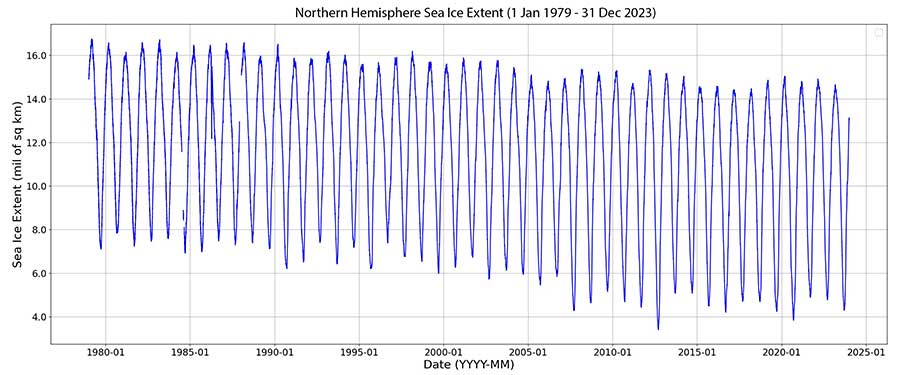
</figure>

### Next Steps

After successful completion of Notebook 4, you can go on to Notebook 5: Compare NOAA/NSIDC SIC CDR to Other SIC Data.

### Data Statement

Meier, W. N., Fetterer, F., Windnagel, A. K., & Stewart, J. S. (2021). NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration. (G02202, Version 4). [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/efmz-2t65.

### Metadata

* Language/Package(s)
  * Python
  * xarray
  * pystac
  * netcdf4
  * pandas
  * numpy
  * matplotlib
* Geophysical Keywords
  * Sea Ice Concentration

### Software License

Copyright 2025 NOAA NCAI

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Content License

[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/ "Createive Commons BY 4.0 License")

### Disclaimer

This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, the United States Department of Commerce, the National Snow and Ice Data Center, or the University of Colorado at Boulder. All NOAA Jupyter notebooks are provided on an 'as is' basis, and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.